# Embeddings with swissmetro 

By: Francisco C. Pereira - camara@dtu.dk, Technical University of Denmark (DTU)
July, 2019

This notebook aims to illustrate the use of Python Travel Embeddings package (PyTre) in a mode choice problem. We use the Swissmetro dataset (https://biogeme.epfl.ch/examples_swissmetro.html) as well as PyLogit (https://github.com/timothyb0912/pylogit).

Besides installing PyTre and Pylogit, you need to have keras installed as well as the typical Scipy suite. 

This code was designed for (and is therfore a companion to) the working paper _"Re-representing travel behavior through embeddings", Francisco C. Pereira_ and therefore contains the respective parameters, thresholds or whatever particular choices were made and explained there. Of course, feel free to change whatever.

In [69]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import pickle
import scipy.spatial
import matplotlib.cm as cm
import scipy.stats
import tensorflow as tf
import keras

import math
from collections import OrderedDict 


from keras.layers.core import Dense, Activation, Dropout, Flatten
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
from keras.layers import BatchNormalization, Input, concatenate
import tempfile
import keras.models
from keras.models import Model, Sequential, load_model
from keras import regularizers
from keras.callbacks import ModelCheckpoint
import keras.backend as K

from sklearn.linear_model  import LogisticRegressionCV, LogisticRegression
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE, MDS
from sklearn.model_selection import train_test_split


import pylogit as pl                   # For MNL model estimation and
                        
import PyTre

We will follow a 3-way validation method, where we split the dataset into three parts: training, development and test set. Let's set the proportion of training set

**note: as you will notice, we'll start splitting into 80/20 for train/test, then extract 25% of the training set to be development. It's easier to only split the training set later, because we'll need to prepare data consistently on the training set size.**

In [70]:
SPLIT_EMBEDDINGS_DCM=.80
TRAINSET_WITHOUT_DEV=.75

Make sure you have the swissmetro.dat file. We use the swissmetro_rand.dat, because we shuffle the original dataset (check "swissmetro_data_prep.ipynb" file)

In [71]:
sw_df_full=pd.read_csv('swissmetro_rand.dat')

There is some repeated warnings (e.g. should use .loc instead of a replace pandas function doesn't seem to be deprecated). If you're using a much later Python version (after July 2019), we recommend to comment the code below and run the whole notebook to check if there are important warnings.

In [72]:
import warnings
warnings.filterwarnings('ignore')

----------

## Some data preparation

Let's extract the corresponding part of the database (determined by SPLIT_EMBEDDINGS_DCM). We are **not** shuffling just to make the results consistent. Notice that we have already shuffled it in the data preparation file.

In [73]:
sw_df,_=train_test_split(sw_df_full, train_size=SPLIT_EMBEDDINGS_DCM, shuffle=False)

The code below serves only for readability later on. We replace each categorical value (typically a number 0-N) with its description string. 

In [74]:
tickets={0: 'None', 1: '2 way w 1/2 price', 2: '1 way w 1/2 price', 3: '2 way normal price', 4: '1 way normal price', 5: 'Half day', 6: 'Annual ticket', 7: 'Annual ticket Junior or Senior', 8: 'Free travel after 7pm', 9: 'Group ticket', 10: 'Other'}
ages={1: 'age≤24', 2: '24<age≤39', 3: '39<age≤54', 4: '54<age≤ 65', 5: '65 <age', 6: 'not known'}
incomes={0:'under 50', 1: 'under 50', 2: 'between 50 and 100', 3: 'over 100', 4: 'unknown'}
whos={0: 'unknown', 1: 'self', 2: 'employer', 3: 'half-half'}
cantons={1:'ZH', 2: 'BE', 3: 'LU', 4:'UR', 5:'SZ', 6:'OW', 7:'NW', 8:'GL', 9:'ZG', 10: 'FR', 11: 'SO', 12:'BS', 13:'BL', 
         14:'SH', 15: 'AR', 16:'AI', 17:'SG', 18:'GR', 19:'AG', 20: 'TH', 21: 'TI', 22:'VD', 23:'VS', 24: 'NE', 25:'GE', 26:'JU'}


def update_table_codes(dic, df, column):
    for t in dic:
        df[column]=df[column].replace(t, dic[t])
    return df
    
sw_df=update_table_codes(tickets, sw_df, 'TICKET')
sw_df=update_table_codes(ages, sw_df, 'AGE')
sw_df=update_table_codes(incomes, sw_df, 'INCOME')
se_df=update_table_codes(whos, sw_df, 'WHO')
    

The dataset comes with origin and destination separate in different columns, and we want to use OD as a variable, so we need pair them up

In [75]:
#combines a list of variables into a single one where its content is the concatenation of values in the list
#In our OD case, we combine ['ORIGIN', 'DEST'] into "OD", where "OD" becomes values like GE_ZH, BE_LU...
#ONLY for categorical variables
def pair_up(df, pair_name, varlist, enforce_int=False): 
    new_df=df[:]
    new_var=[]
    for index, row in new_df.iterrows():
        nv=""
        for v in varlist:
            val=row[v]
            if enforce_int:
                val=int(val)
            #nv+=str(val)+"_"
            nv+=cantons[val]+"_"
        nv=nv[:-1]
        new_var.append(nv)
    new_df[pair_name]=new_var
    
    return new_df

In [76]:
sw_df=pair_up(sw_df, "OD", ['ORIGIN', 'DEST'])

## Creation of the embeddings

Let's do our embeddings then. 

First, we need to decide which variables we want to create embeddings for

In [77]:
emb_vars=['OD', 'TICKET', 'WHO', 'AGE', 'INCOME']


Second, we need to decide, for EACH embeddings variable (emb_var), what embeddings size will be used

**note: you could actually can skip this step, and just let PyTre determine the embeddings size for us. Internally, it will apply PCA to each variable and select the number of eigenvectors with a certain variance explained (varexp, default 90%). This does not give the best results, however, with the Swissmetro dataset. No reason not to try it with your own dataset**

In [78]:
EMB_SIZES=[3, 5,1, 3, 3]

Ah, also important: which exogenous variables do you want to give the embeddings model to estimate with. Ideally, you should use the exact same variables you will later use in your model

In [79]:
ex_vars=['CAR_TT', 'TRAIN_TT', 'SM_TT', 'FIRST', 'SURVEY']


Of course, you need to specify the target variable for the embeddings. Since we're making embeddings for mode, we use the variable "CHOICE" in Swissmetro

In [80]:
y_var=['CHOICE']

Let's create PyTre object...

In [81]:
pt=PyTre.EmbeddingsModel()

In [82]:
sw_df_train,_=train_test_split(sw_df, train_size=TRAINSET_WITHOUT_DEV, shuffle=False)

Let's finally estimate the embeddings. Feel free to play with the parameters to see their effect. Some explanations:
- we give the dataset in different components (x= columns related to the emb_vars; y=target variable;  exogenous=columns related to exogenous variables)
- it may be convenient to send labels (xlabels), just to be able to understand the output better later on
- The EPOCHS variable determines the MAXIMUM number of epochs. Your algorithm might terminate earlier if the stopping condition (not improving for more than 20 epochs). 
- This automatic termination ONLY works if you have a bit of a validation dataset (we use 20% of VALIDATION_SPLIT). If you have it as 0, then it will run EXACTLY the number of EPOCHS you selected
- The variable CRC (default TRUE) adds the regularizer layer (check paper)
- The parameter EMB_SIZE sets the embeddings size for each of the variables. The default is "auto", which automatically determines the numbers through PCA

In [83]:
m, embs=pt.fit(sw_df_train[emb_vars], sw_df_train[y_var], sw_df_train[ex_vars], xlabels=emb_vars, EPOCHS=80, VALIDATION_SPLIT=0.0, verbose=1, EMB_SIZE=EMB_SIZES)

Epoch 1/80
6414/6414 [==============================] - 2s 328us/step - loss: 15.3965 - output_layer_loss: 3.5818 - crc_embeddings_OD_loss: 4.5363 - crc_embeddings_TICKET_loss: 2.1406 - crc_embeddings_WHO_loss: 1.3625 - crc_embeddings_AGE_loss: 1.5710 - crc_embeddings_INCOME_loss: 1.3270
Epoch 2/80
6414/6414 [==============================] - 1s 115us/step - loss: 13.1022 - output_layer_loss: 1.8346 - crc_embeddings_OD_loss: 4.4877 - crc_embeddings_TICKET_loss: 2.0367 - crc_embeddings_WHO_loss: 1.3216 - crc_embeddings_AGE_loss: 1.4947 - crc_embeddings_INCOME_loss: 1.2630
Epoch 3/80
6414/6414 [==============================] - 1s 114us/step - loss: 11.9679 - output_layer_loss: 1.1373 - crc_embeddings_OD_loss: 4.4419 - crc_embeddings_TICKET_loss: 1.9277 - crc_embeddings_WHO_loss: 1.2826 - crc_embeddings_AGE_loss: 1.4295 - crc_embeddings_INCOME_loss: 1.2011
Epoch 4/80
6414/6414 [==============================] - 1s 115us/step - loss: 11.4125 - output_layer_loss: 0.9745 - crc_embeddings_OD

6414/6414 [==============================] - 1s 115us/step - loss: 7.5667 - output_layer_loss: 0.8095 - crc_embeddings_OD_loss: 3.3480 - crc_embeddings_TICKET_loss: 0.5696 - crc_embeddings_WHO_loss: 0.5587 - crc_embeddings_AGE_loss: 0.5653 - crc_embeddings_INCOME_loss: 0.3247
Epoch 30/80
6414/6414 [==============================] - 1s 116us/step - loss: 7.5304 - output_layer_loss: 0.8014 - crc_embeddings_OD_loss: 3.3273 - crc_embeddings_TICKET_loss: 0.5672 - crc_embeddings_WHO_loss: 0.5606 - crc_embeddings_AGE_loss: 0.5523 - crc_embeddings_INCOME_loss: 0.3199
Epoch 31/80
6414/6414 [==============================] - 1s 112us/step - loss: 7.4858 - output_layer_loss: 0.7869 - crc_embeddings_OD_loss: 3.3222 - crc_embeddings_TICKET_loss: 0.5596 - crc_embeddings_WHO_loss: 0.5535 - crc_embeddings_AGE_loss: 0.5404 - crc_embeddings_INCOME_loss: 0.3113
Epoch 32/80
6414/6414 [==============================] - 1s 109us/step - loss: 7.4795 - output_layer_loss: 0.7939 - crc_embeddings_OD_loss: 3.314

6414/6414 [==============================] - 1s 142us/step - loss: 7.2441 - output_layer_loss: 0.7746 - crc_embeddings_OD_loss: 3.2599 - crc_embeddings_TICKET_loss: 0.5312 - crc_embeddings_WHO_loss: 0.4818 - crc_embeddings_AGE_loss: 0.4398 - crc_embeddings_INCOME_loss: 0.2598
Epoch 58/80
6414/6414 [==============================] - 1s 110us/step - loss: 7.2473 - output_layer_loss: 0.7729 - crc_embeddings_OD_loss: 3.2628 - crc_embeddings_TICKET_loss: 0.5296 - crc_embeddings_WHO_loss: 0.4808 - crc_embeddings_AGE_loss: 0.4389 - crc_embeddings_INCOME_loss: 0.2637
Epoch 59/80
6414/6414 [==============================] - 1s 113us/step - loss: 7.2493 - output_layer_loss: 0.7782 - crc_embeddings_OD_loss: 3.2597 - crc_embeddings_TICKET_loss: 0.5303 - crc_embeddings_WHO_loss: 0.4764 - crc_embeddings_AGE_loss: 0.4385 - crc_embeddings_INCOME_loss: 0.2647
Epoch 60/80
6414/6414 [==============================] - 1s 113us/step - loss: 7.2368 - output_layer_loss: 0.7716 - crc_embeddings_OD_loss: 3.252

The typical loss plot

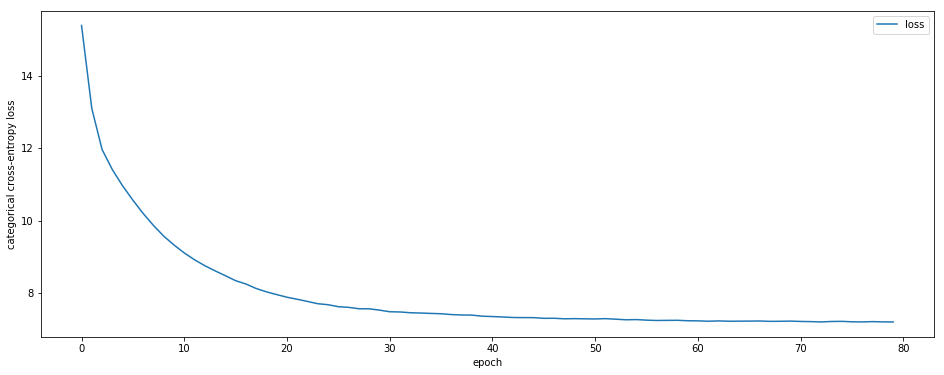

In [84]:
plt.figure(figsize=(16,6))
plt.plot(pt.model.history.history['loss'])
#plt.plot(pt.model.history.history['val_loss'])
plt.legend(['loss'])#, 'val loss'])
plt.xlabel("epoch")
plt.ylabel("categorical cross-entropy loss")
plt.show()

And now the MDS visualizations of the embeddings (see paper)

**note: as the paper mentions, the axes do not mean anything in particular. More importantly, each time we run this, we may get different rotations (but the distances remain).**

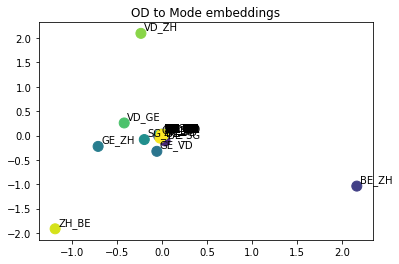

In [85]:
pt.visualize_embeddings(pt.embeddings_dic['OD']['embeddings'], pt.embeddings_dic['OD']['index2alfa_from'], adjust=False, fromlabel='OD', tolabel="Mode")


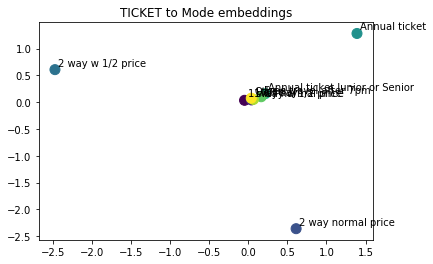

In [86]:
pt.visualize_embeddings(pt.embeddings_dic['TICKET']['embeddings'], pt.embeddings_dic['TICKET']['index2alfa_from'], adjust=False, fromlabel='TICKET', tolabel="Mode")

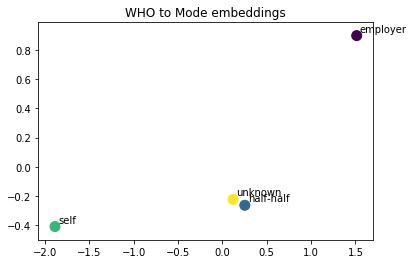

In [87]:
pt.visualize_embeddings(pt.embeddings_dic['WHO']['embeddings'], pt.embeddings_dic['WHO']['index2alfa_from'], adjust=False, fromlabel='WHO', tolabel="Mode")


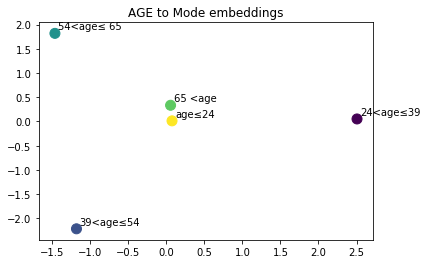

In [88]:

pt.visualize_embeddings(pt.embeddings_dic['AGE']['embeddings'], pt.embeddings_dic['AGE']['index2alfa_from'], adjust=False, fromlabel='AGE', tolabel="Mode")


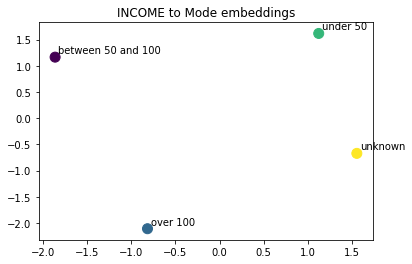

In [89]:
pt.visualize_embeddings(pt.embeddings_dic['INCOME']['embeddings'], pt.embeddings_dic['INCOME']['index2alfa_from'], adjust=False, fromlabel='INCOME', tolabel="Mode")

It is often useful to plot the distance distribution for an embeddings matrix. If this distribution is concentrated around the same value (i.e. all categories fall in roughly the same distance from each other), then an embeddings encoding will not add much value in comparison with dummies.

A particular case is when there is high concentration around zero. This means that at least some of the categories can just be grouped together into a single one (e.g. a single dummy variable).

In [90]:
def plot_distance_histogram(embs, bins=None):
        if embs in pt.embeddings_dic.keys():
            embs=pt.embeddings_dic[embs]['embeddings']
            
        distances=[]
        
        for e1 in embs:
            for e2 in embs:
                if (e1==e2).all():
                    continue
                distances.append(np.linalg.norm(e1-e2))
                
        if bins!=None:
            plt.hist(distances, bins)
        else:
            plt.hist(distances)
        plt.show()


Let's do for the ODs

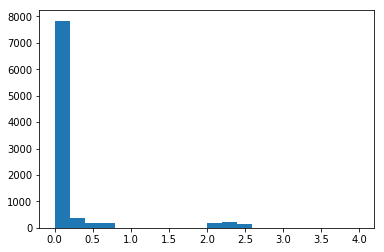

In [91]:
plot_distance_histogram('OD', 20)

As mentioned in the paper, the vast majority of the ODs don't really distinguish much from each other, which means that they could be grouped into one. There are, however, a few exceptions, and this is clear in the picture...

The paper also shows that TICKET variable is not very successful

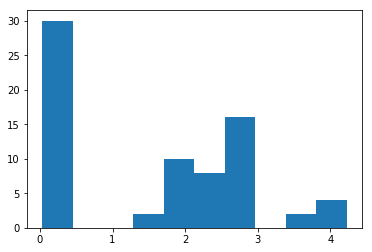

In [97]:
plot_distance_histogram('TICKET', 10)

What does this mean?...

------------------------------------------

## Original PyLogit model estimation 

Pylogit needs data in the "Long format", so let's use the prepared file (to see how it's created, check swissmetro_data_prep paper.ipynb)

In [98]:
long_swiss_metro_full=pd.read_csv("long_swissmetro_rand.dat")


In [99]:
long_swiss_metro=pair_up(long_swiss_metro_full, "OD", ['ORIGIN', 'DEST'], True)

Given the relatively small size of the dataset, it's not surprising that there may be OD pairs that happen to only be observed in the test set - this would later crash any of the algorithms, so we remove them

In [100]:

all_ODs=list(long_swiss_metro['OD'].unique())

remove_ODs=[od for od in all_ODs if od not in list(pt.embeddings_dic['OD']['index2alfa_from'].values())]
for r in remove_ODs:
    long_swiss_metro=long_swiss_metro[long_swiss_metro.OD!=r]


This is the list of ODs that are NOT in the training set but can be found in the test set

In [101]:
print(remove_ODs)

['VD_VD', 'TH_AG', 'AR_AG', 'AR_GE', 'TH_VS', 'GE_JU', 'BE_ZG', 'FR_GR', 'SG_VS', 'TI_VD', 'SG_ZG', 'SZ_VD']


Same treatment as before, for interpretability of the results

In [102]:
long_swiss_metro=update_table_codes(tickets, long_swiss_metro, 'TICKET')
long_swiss_metro=update_table_codes(ages, long_swiss_metro, 'AGE')
long_swiss_metro=update_table_codes(incomes, long_swiss_metro, 'INCOME')
long_swiss_metro=update_table_codes(whos, long_swiss_metro, 'WHO')

The code below comes from the PyLogit example, which is also with Swissmetro. We're essentially creating a few variables that are needed for the MNL estimation

In [103]:
# Create the list of individual specific variables
ind_variables = sw_df.columns.tolist()[:15]

# Specify the variables that vary across individuals and some or all alternatives
# The keys are the column names that will be used in the long format dataframe.
# The values are dictionaries whose key-value pairs are the alternative id and
# the column name of the corresponding column that encodes that variable for
# the given alternative. Examples below.
alt_varying_variables = {u'travel_time': dict([(1, 'TRAIN_TT'),
                                               (2, 'SM_TT'),
                                               (3, 'CAR_TT')]),
                          u'travel_cost': dict([(1, 'TRAIN_CO'),
                                                (2, 'SM_CO'),
                                                (3, 'CAR_CO')]),
                          u'headway': dict([(1, 'TRAIN_HE'),
                                            (2, 'SM_HE')]),
                          u'seat_configuration': dict([(2, "SM_SEATS")])}

# Specify the availability variables
# Note that the keys of the dictionary are the alternative id's.
# The values are the columns denoting the availability for the
# given mode in the dataset.
availability_variables = {1: 'TRAIN_AV',
                          2: 'SM_AV', 
                          3: 'CAR_AV'}

##########
# Determine the columns for: alternative ids, the observation ids and the choice
##########
# The 'custom_alt_id' is the name of a column to be created in the long-format data
# It will identify the alternative associated with each row.
custom_alt_id = "mode_id"

# Create a custom id column that ignores the fact that this is a 
# panel/repeated-observations dataset. Note the +1 ensures the id's start at one.
obs_id_column = "custom_id"
sw_df[obs_id_column] = np.arange(sw_df.shape[0],
                                            dtype=int) + 1


# Create a variable recording the choice column
choice_column = "CHOICE"

In [104]:
##########
# Create scaled variables so the estimated coefficients are of similar magnitudes
##########
# Scale the travel time column by 60 to convert raw units (minutes) to hours
long_swiss_metro["travel_time_hrs"] = long_swiss_metro["travel_time"] / 60.0

# Scale the headway column by 60 to convert raw units (minutes) to hours
long_swiss_metro["headway_hrs"] = long_swiss_metro["headway"] / 60.0

# Figure out who doesn't incur a marginal cost for the ticket
# This can be because he/she owns an annual season pass (GA == 1) 
# or because his/her employer pays for the ticket (WHO == 2).
# Note that all the other complexity in figuring out ticket costs
# have been accounted for except the GA pass (the annual season
# ticket). Make sure this dummy variable is only equal to 1 for
# the rows with the Train or Swissmetro
long_swiss_metro["free_ticket"] = (((long_swiss_metro["GA"] == 1) |
                                    (long_swiss_metro["WHO"] == 2)) &
                                   long_swiss_metro[custom_alt_id].isin([1,2])).astype(int)
# Scale the travel cost by 100 so estimated coefficients are of similar magnitude
# and acccount for ownership of a season pass
long_swiss_metro["travel_cost_hundreth"] = (long_swiss_metro["travel_cost"] *
                                            (long_swiss_metro["free_ticket"] == 0) /
                                            100.0)

##########
# Create various dummy variables to describe the choice context of a given
# invidual for each choice task.
##########
# Create a dummy variable for whether a person has a single piece of luggage
long_swiss_metro["single_luggage_piece"] = (long_swiss_metro["LUGGAGE"] == 1).astype(int)

# Create a dummy variable for whether a person has multiple pieces of luggage
long_swiss_metro["multiple_luggage_pieces"] = (long_swiss_metro["LUGGAGE"] == 3).astype(int)

# Create a dummy variable indicating that a person is NOT first class
long_swiss_metro["regular_class"] = 1 - long_swiss_metro["FIRST"]

# Create a dummy variable indicating that the survey was taken aboard a train
# Note that such passengers are a-priori imagined to be somewhat partial to train modes
long_swiss_metro["train_survey"] = 1 - long_swiss_metro["SURVEY"]


Since we will repeat multiple estimations that extend on the same original basis, we have this function will be called at the beggining of each new model specification. All these elements will be repeated in all models. 

In [105]:
def create_spec():
    # NOTE: - Specification and variable names must be ordered dictionaries.
    #       - Keys should be variables within the long format dataframe.
    #         The sole exception to this is the "intercept" key.
    #       - For the specification dictionary, the values should be lists
    #         of integers or lists of lists of integers. Within a list, 
    #         or within the inner-most list, the integers should be the 
    #         alternative ID's of the alternative whose utility specification 
    #         the explanatory variable is entering. Lists of lists denote 
    #         alternatives that will share a common coefficient for the variable
    #         in question.

    basic_specification = OrderedDict()
    basic_names = OrderedDict()

    basic_specification["intercept"] = [1, 2]
    basic_names["intercept"] = ['ASC Train',
                                'ASC Swissmetro']

    basic_specification["travel_time_hrs"] = [[1, 2,], 3]
    basic_names["travel_time_hrs"] = ['Travel Time, units:hrs (Train and Swissmetro)',
                                      'Travel Time, units:hrs (Car)']

    basic_specification["travel_cost_hundreth"] = [1, 2, 3]
    basic_names["travel_cost_hundreth"] = ['Travel Cost * (Annual Pass == 0), units: 0.01 CHF (Train)',
                                           'Travel Cost * (Annual Pass == 0), units: 0.01 CHF (Swissmetro)',
                                           'Travel Cost, units: 0.01 CHF (Car)']

    basic_specification["headway_hrs"] = [1, 2]
    basic_names["headway_hrs"] = ["Headway, units:hrs, (Train)",
                                  "Headway, units:hrs, (Swissmetro)"]

    basic_specification["seat_configuration"] = [2]
    basic_names["seat_configuration"] = ['Airline Seat Configuration, base=No (Swissmetro)']

    basic_specification["train_survey"] = [[1, 2]]
    basic_names["train_survey"] = ["Surveyed on a Train, base=No, (Train and Swissmetro)"]

    basic_specification["regular_class"] = [1]
    basic_names["regular_class"] = ["First Class == False, (Swissmetro)"]

    basic_specification["single_luggage_piece"] = [3]
    basic_names["single_luggage_piece"] = ["Number of Luggage Pieces == 1, (Car)"]

    basic_specification["multiple_luggage_pieces"] = [3]
    basic_names["multiple_luggage_pieces"] = ["Number of Luggage Pieces > 1, (Car)"]
    
    return basic_specification, basic_names


Our experiemental design expects that the training set of embeddings is the same one as all other models (it could be different, if we wanted to assume that we had a prior dataset only for embeddings/eigenvectors training, as we also do in section 5.6 of the paper, "Embeddings for efficient survey data usage"). 

In [106]:
long_swiss_metro_train,long_swiss_metro_test=train_test_split(long_swiss_metro, train_size=SPLIT_EMBEDDINGS_DCM, shuffle=False)

Notice that this time we keep a testset variable, that will be used later to validate the model


As said, we start with the simplest of the models (the original one in PyLogit package)

In [107]:
basic_specification, basic_names=create_spec()

In [108]:
long_swiss_metro_train_train,long_swiss_metro_train_train_dev=train_test_split(long_swiss_metro_train, train_size=TRAINSET_WITHOUT_DEV, shuffle=False)


In [111]:
# Estimate the multinomial logit model (MNL)
swissmetro_mnl = pl.create_choice_model(data=long_swiss_metro_train_train,
                                        alt_id_col=custom_alt_id,
                                        obs_id_col=obs_id_column,
                                        choice_col=choice_column,
                                        specification=basic_specification,
                                        model_type="MNL",
                                        names=basic_names)


deg_freedom=sum([len(b) for b in basic_specification.values()])
# Specify the initial values and method for the optimization.
swissmetro_mnl.fit_mle(np.zeros(deg_freedom))

# Look at the estimation results
swissmetro_mnl.get_statsmodels_summary()

Log-likelihood at zero: -6,559.9046
Initial Log-likelihood: -6,559.9046
Estimation Time for Point Estimation: 0.37 seconds.
Final log-likelihood: -4,695.8156


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                      CHOICE   No. Observations:                6,373
Model:             Multinomial Logit Model   Df Residuals:                    6,359
Method:                                MLE   Df Model:                           14
Date:                     Fri, 30 Aug 2019   Pseudo R-squ.:                   0.284
Time:                             01:16:32   Pseudo R-bar-squ.:               0.282
AIC:                             9,419.631   Log-Likelihood:             -4,695.816
BIC:                             9,514.269   LL-Null:                    -6,559.905
==================================================================================================================================
                                                                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------
ASC Train                                                         -0.5660      0.158     -3.575      0.000      -0.876      -0.256
ASC Swissmetro                                                    -0.3532      0.121     -2.929      0.003      -0.590      -0.117
Travel Time, units:hrs (Train and Swissmetro)                     -0.6815      0.041    -16.432      0.000      -0.763      -0.600
Travel Time, units:hrs (Car)                                      -0.7186      0.049    -14.752      0.000      -0.814      -0.623
Travel Cost * (Annual Pass == 0), units: 0.01 CHF (Train)         -1.6303      0.096    -17.055      0.000      -1.818      -1.443
Travel Cost * (Annual Pass == 0), units: 0.01 CHF (Swissmetro)    -0.7797      0.047    -16.458      0.000      -0.872      -0.687
Travel Cost, units: 0.01 CHF (Car)                                -1.0766      0.116     -9.271      0.000      -1.304      -0.849
Headway, units:hrs, (Train)                                       -0.3296      0.065     -5.102      0.000      -0.456      -0.203
Headway, units:hrs, (Swissmetro)                                  -0.5052      0.203     -2.484      0.013      -0.904      -0.107
Airline Seat Configuration, base=No (Swissmetro)                  -0.5768      0.093     -6.192      0.000      -0.759      -0.394
Surveyed on a Train, base=No, (Train and Swissmetro)               3.0548      0.141     21.732      0.000       2.779       3.330
First Class == False, (Swissmetro)                                 0.0408      0.084      0.483      0.629      -0.125       0.206
Number of Luggage Pieces == 1, (Car)                               0.3868      0.070      5.564      0.000       0.251       0.523
Number of Luggage Pieces > 1, (Car)                                2.0613      0.364      5.659      0.000       1.347       2.775
==================================================================================================================================
"""

We will need to get statistics for the testset


In [112]:
testsetsize=len(long_swiss_metro_test)/3 #We divide by 3, because it's a long format (three rows per data point, one per choice)

#Calculation of log likelihood for the testset
long_probs=swissmetro_mnl.predict(long_swiss_metro_test)
SCORE=sum([np.log(x) for x in np.multiply(long_probs, long_swiss_metro_test['CHOICE']) if x!=0.0])

SCORE_ORIGINAL=SCORE

#calculation of the several metrics
obs_ll=swissmetro_mnl.null_log_likelihood/swissmetro_mnl.nobs #this extracts the null likelihood per observation 
rsq=1-(SCORE/(obs_ll*testsetsize)) 
adjrsq=rsq-(1-rsq)*deg_freedom/(testsetsize-deg_freedom-1)
AIC=2*deg_freedom-2*SCORE
BIC=math.log(testsetsize)*deg_freedom-2*SCORE
print("model results for ORIGINAL (%d observations, %d degrees of freedom)"%(testsetsize,deg_freedom))
print("Log likelihood (testset)=%f"%SCORE)
print("R^2 test=%f & adjusted R^2 test=%f"%(rsq, adjrsq))
print("AIC test=%f & BIC test=%f"%(AIC, BIC))    


model results for ORIGINAL (2003 observations, 14 degrees of freedom)
Log likelihood (testset)=-1486.265921
R^2 test=0.279362 & adjusted R^2 test=0.274288
AIC test=3000.531842 & BIC test=3078.970119


-------------------

## Now with embeddings in the ODs

Let us now turn to the embeddings model. The first thing to do is to encode the corresponding variables. 

In [113]:
#This function replaces all values in emb_vars columns by their embeddings representations
new_long_sw_df=pt.replace_with_embeddings(long_swiss_metro, emb_vars)

We will now create the model MNL specification for embeddings. 

We need to go over the new variable names, but first lets create their list.

In [114]:
emb_vars_long=[item for sublist in [[v for v in new_long_sw_df.columns if v.startswith(x)] for x in emb_vars] for item in sublist]

As mentioned, we start by reusing the original specification (create_spec()). And then, we associate the embeddings variables. Notice that "TICKET" only makes sense for the Train alternative. 

In [115]:
basic_specification, basic_names=create_spec()
for emb in emb_vars_long: 
    if emb.startswith("TICKET"):  #only for train
        basic_specification[emb] = [1]
        basic_names[emb] = [emb+"_Train"]
    else:
        #if emb.startswith("OD"):
        #    continue
        basic_specification[emb] = [1,2]   #for train and SM (Car is the default category)
        basic_names[emb] = [emb+"_Train", emb+"_SM"]

The usual train/test split  and model estimation

In [117]:
new_long_sw_df_train,new_long_sw_df_test=train_test_split(new_long_sw_df, train_size=SPLIT_EMBEDDINGS_DCM, shuffle=False)

In [118]:
new_long_sw_df_train_without_dev,new_long_sw_df_dev=train_test_split(new_long_sw_df_train, train_size=TRAINSET_WITHOUT_DEV, shuffle=False)


In [120]:
# Estimate the multinomial logit model (MNL)
swissmetro_mnl = pl.create_choice_model(data=new_long_sw_df_train_without_dev,
                                        alt_id_col=custom_alt_id,
                                        obs_id_col=obs_id_column,
                                        choice_col=choice_column,
                                        specification=basic_specification,
                                        model_type="MNL",
                                        names=basic_names)

deg_freedom=sum([len(b) for b in basic_specification.values()])
# Specify the initial values and method for the optimization.
swissmetro_mnl.fit_mle(np.zeros(deg_freedom))

# Look at the estimation results
swissmetro_mnl.get_statsmodels_summary()

Log-likelihood at zero: -6,559.9046
Initial Log-likelihood: -6,559.9046
Estimation Time for Point Estimation: 1.09 seconds.
Final log-likelihood: -4,425.1578


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                      CHOICE   No. Observations:                6,373
Model:             Multinomial Logit Model   Df Residuals:                    6,334
Method:                                MLE   Df Model:                           39
Date:                     Fri, 30 Aug 2019   Pseudo R-squ.:                   0.325
Time:                             01:17:13   Pseudo R-bar-squ.:               0.319
AIC:                             8,928.316   Log-Likelihood:             -4,425.158
BIC:                             9,191.949   LL-Null:                    -6,559.905
==================================================================================================================================
                                                                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------
ASC Train                                                         -0.8342      0.198     -4.218      0.000      -1.222      -0.447
ASC Swissmetro                                                    -0.3292      0.137     -2.400      0.016      -0.598      -0.060
Travel Time, units:hrs (Train and Swissmetro)                     -0.6152      0.042    -14.521      0.000      -0.698      -0.532
Travel Time, units:hrs (Car)                                      -0.7164      0.050    -14.467      0.000      -0.813      -0.619
Travel Cost * (Annual Pass == 0), units: 0.01 CHF (Train)         -0.9530      0.099     -9.615      0.000      -1.147      -0.759
Travel Cost * (Annual Pass == 0), units: 0.01 CHF (Swissmetro)    -0.8625      0.050    -17.402      0.000      -0.960      -0.765
Travel Cost, units: 0.01 CHF (Car)                                -0.9989      0.119     -8.393      0.000      -1.232      -0.766
Headway, units:hrs, (Train)                                       -0.3967      0.070     -5.645      0.000      -0.534      -0.259
Headway, units:hrs, (Swissmetro)                                  -0.5891      0.206     -2.853      0.004      -0.994      -0.184
Airline Seat Configuration, base=No (Swissmetro)                  -0.4161      0.101     -4.113      0.000      -0.614      -0.218
Surveyed on a Train, base=No, (Train and Swissmetro)               2.9397      0.144     20.394      0.000       2.657       3.222
First Class == False, (Swissmetro)                                -0.0456      0.104     -0.437      0.662      -0.250       0.159
Number of Luggage Pieces == 1, (Car)                               0.3558      0.071      5.012      0.000       0.217       0.495
Number of Luggage Pieces > 1, (Car)                                1.9135      0.375      5.101      0.000       1.178       2.649
OD0_Train                                                         -0.1061      0.086     -1.227      0.220      -0.276       0.063
OD0_SM                                                            -0.1073      0.059     -1.828      0.068      -0.222       0.008
OD1_Train                                                          0.1691      0.139      1.220      0.223      -0.103       0.441
OD1_SM                                                             0.1596      0.078      2.035      0.042       0.006       0.313
OD2_Train                                                          0.1663      0.145      1.144      0.253      -0.119       0.451
OD2_SM                                                             0.3188      0.091      3.499      0.000       0.140       0.497
TICKET0_Train                                                     29.2176      6.436      4.540      0.000      16.604      41.832
TICKET1_Train                                       

In [121]:
testsetsize=len(new_long_sw_df_test)/3 #We divide by 3, because it's a long format (three rows per data point, one per choice)

#Calculation of log likelihood for the testset
long_probs=swissmetro_mnl.predict(new_long_sw_df_test)
SCORE=sum([np.log(x) for x in np.multiply(long_probs, new_long_sw_df_test['CHOICE']) if x!=0.0])

SCORE_EMBEDDINGS=SCORE

#calculation of the several metrics
obs_ll=swissmetro_mnl.null_log_likelihood/swissmetro_mnl.nobs #this extracts the null likelihood per observation 
rsq=1-(SCORE/(obs_ll*testsetsize)) 
adjrsq=rsq-(1-rsq)*deg_freedom/(testsetsize-deg_freedom-1)
AIC=2*deg_freedom-2*SCORE
BIC=math.log(testsetsize)*deg_freedom-2*SCORE
print("model results for EMBEDDINGS (%d observations, %d degrees of freedom)"%(testsetsize,deg_freedom))
print("Log likelihood (testset)=%f"%SCORE)
print("R^2 test=%f & adjusted R^2 test=%f"%(rsq, adjrsq))
print("AIC test=%f & BIC test=%f"%(AIC, BIC))    


model results for EMBEDDINGS (2003 observations, 39 degrees of freedom)
Log likelihood (testset)=-1417.004854
R^2 test=0.312944 & adjusted R^2 test=0.299298
AIC test=2912.009708 & BIC test=3130.516339


In order to get the coefficients and p-values, we need to project back to the "original" dummy variable space

**note: the output is in latex form, to be easier to use in the paper... ;-)**

In [124]:
print("variable name\tcoeff\tstderr\tz-score\tp-value")

count=0
countsig=0
for var in emb_vars:#['OD', 'WHO', 'TICKET', 'INCOME', 'AGE']:#

    alfs=pt.embeddings_dic[var]['index2alfa_from']
    embs=pt.embeddings_dic[var]['embeddings']

    alternatives=['Train', 'SM']
    if var in ["TICKET"]:#, "OD"]:
        alternatives=['Train']
    for m in alternatives:
        for i in range(embs.shape[0]):
            mean=0
            stde=0
            mean_default=0
            stde_default=0
            for j in range(embs.shape[1]):
                mean+=embs[i,j]*swissmetro_mnl.coefs[var+str(j)+"_"+m]
                stde+=embs[i,j]**2*swissmetro_mnl.standard_errors[var+str(j)+"_"+m]**2
            if i==0:
                stde_default=stde
                mean_default=mean
                continue
            stde=math.sqrt(stde+stde_default)
            z_score=(mean-mean_default)/stde        
            p_value = scipy.stats.norm.sf(abs(z_score))*2 #twosided
            signif=""
            if p_value<0.05:
                signif="**"
                countsig+=1
            elif p_value<0.1:
                signif="*"
                countsig+=1
            #print(var+str(i)+"_"+m+"\t%.3f\t%.3f\t%.3f\t%.3f%s"% (mean, stde, z_score, p_value, signif))
            #print(alfs[i]+"_"+m+"\t%.3f\t%.3f\t%.3f\t%.3f%s"% (mean, stde, z_score, p_value, signif))
            if signif!="" or var!="OD":
                print(var+"_"+alfs[i]+"_"+m+"&%.3f&%.3f&%.3f&%.3f%s\\\\"% (mean, stde, z_score, p_value, signif))
            count+=1



        
            

variable name	coeff	stderr	z-score	p-value
OD_BE_GE_Train&-0.003&0.001&-1.914&0.056*\\
OD_BE_SH_Train&-0.001&0.001&-1.829&0.067*\\
OD_BE_VD_Train&-0.005&0.003&-1.928&0.054*\\
OD_FR_TH_Train&-0.001&0.000&-2.068&0.039**\\
OD_GE_FR_Train&-0.003&0.001&-1.927&0.054*\\
OD_GE_VD_Train&-0.090&0.047&-1.900&0.057*\\
OD_GE_VS_Train&-0.001&0.001&-1.838&0.066*\\
OD_GE_ZH_Train&-0.194&0.098&-1.971&0.049**\\
OD_SG_BE_Train&-0.047&0.027&-1.722&0.085*\\
OD_VD_BE_Train&-0.006&0.003&-1.985&0.047**\\
OD_VD_SG_Train&-0.004&0.002&-1.806&0.071*\\
OD_ZG_BE_Train&-0.001&0.001&-1.716&0.086*\\
OD_ZG_SG_Train&-0.000&0.000&-2.049&0.041**\\
OD_ZG_VS_Train&-0.001&0.000&-1.948&0.051*\\
OD_ZH_GE_Train&-0.004&0.002&-1.924&0.054*\\
OD_ZH_SG_Train&-0.005&0.003&-2.042&0.041**\\
OD_ZH_VD_Train&-0.020&0.010&-1.977&0.048**\\
OD_AG_GE_SM&-0.001&0.000&-3.037&0.002**\\
OD_AG_VD_SM&0.000&0.000&2.561&0.010**\\
OD_AG_ZH_SM&-0.001&0.000&-2.990&0.003**\\
OD_AR_BE_SM&-0.001&0.000&-3.253&0.001**\\
OD_AR_ZH_SM&-0.002&0.001&-3.609&0.000

-----------------

## Now with dummy variable model

Let's start by applying the dummy encoding into the emb_vars variables

In [125]:
dummy_long_sw_df=pd.get_dummies(long_swiss_metro, columns=emb_vars, drop_first=True)

Same as before: in order to create the specification, we need to get the list of new variables (dataframe columns) that correspond to the dummy variables

In [126]:
dummy_vars_long=[item for sublist in [[v for v in dummy_long_sw_df.columns if v.startswith(x)] for x in emb_vars] for item in sublist]

There's a new subtlety here: as explained in the paper, if we use the OD variables (as dummies), the result is catastrophic, so we include a model without those variables to keep it a decent baseline.  

In [127]:
exclude_ODs=[d for d in dummy_vars_long if not d.startswith("OD")]

In [128]:
basic_specification, basic_names=create_spec()
#for dum in dummy_vars_long: #if you want to try the model including OD variables, replace the line below with this one. 
for dum in exclude_ODs:
    if dum.startswith("TICKET"):
        basic_specification[dum] = [1]
        basic_names[dum] = [dum+"_Train"]
    else:
        basic_specification[dum] = [1,2]
        basic_names[dum] = [dum+"_Train", dum+"_SM"]

In [129]:
dummy_long_sw_df_train,dummy_long_sw_df_test=train_test_split(dummy_long_sw_df, train_size=SPLIT_EMBEDDINGS_DCM, shuffle=False)

In [130]:
dummy_long_sw_df_train_train,dummy_long_sw_df_train_dev=train_test_split(dummy_long_sw_df_train, train_size=TRAINSET_WITHOUT_DEV, shuffle=False)


In [131]:
# Estimate the multinomial logit model (MNL)
swissmetro_mnl = pl.create_choice_model(data=dummy_long_sw_df_train_train,
                                        alt_id_col=custom_alt_id,
                                        obs_id_col=obs_id_column,
                                        choice_col=choice_column,
                                        specification=basic_specification,
                                        model_type="MNL",
                                        names=basic_names)

deg_freedom=sum([len(b) for b in basic_specification.values()])
# Specify the initial values and method for the optimization.
swissmetro_mnl.fit_mle(np.zeros(deg_freedom))


# Look at the estimation results
swissmetro_mnl.get_statsmodels_summary()

Log-likelihood at zero: -6,559.9046
Initial Log-likelihood: -6,559.9046
Estimation Time for Point Estimation: 1.80 seconds.
Final log-likelihood: -4,386.9242


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                      CHOICE   No. Observations:                6,373
Model:             Multinomial Logit Model   Df Residuals:                    6,331
Method:                                MLE   Df Model:                           42
Date:                     Fri, 30 Aug 2019   Pseudo R-squ.:                   0.331
Time:                             01:18:55   Pseudo R-bar-squ.:               0.325
AIC:                             8,857.848   Log-Likelihood:             -4,386.924
BIC:                             9,141.761   LL-Null:                    -6,559.905
==================================================================================================================================
                                                                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------
ASC Train                                                         -2.1976      0.464     -4.732      0.000      -3.108      -1.287
ASC Swissmetro                                                    -0.0183      0.147     -0.125      0.901      -0.306       0.269
Travel Time, units:hrs (Train and Swissmetro)                     -0.5777      0.043    -13.481      0.000      -0.662      -0.494
Travel Time, units:hrs (Car)                                      -0.7028      0.049    -14.399      0.000      -0.798      -0.607
Travel Cost * (Annual Pass == 0), units: 0.01 CHF (Train)         -1.3984      0.144     -9.717      0.000      -1.680      -1.116
Travel Cost * (Annual Pass == 0), units: 0.01 CHF (Swissmetro)    -0.8554      0.049    -17.328      0.000      -0.952      -0.759
Travel Cost, units: 0.01 CHF (Car)                                -0.9836      0.118     -8.368      0.000      -1.214      -0.753
Headway, units:hrs, (Train)                                       -0.4318      0.071     -6.042      0.000      -0.572      -0.292
Headway, units:hrs, (Swissmetro)                                  -0.5994      0.207     -2.890      0.004      -1.006      -0.193
Airline Seat Configuration, base=No (Swissmetro)                  -0.4091      0.102     -4.012      0.000      -0.609      -0.209
Surveyed on a Train, base=No, (Train and Swissmetro)               2.9172      0.143     20.364      0.000       2.636       3.198
First Class == False, (Swissmetro)                                 0.0030      0.113      0.026      0.979      -0.218       0.224
Number of Luggage Pieces == 1, (Car)                               0.3632      0.072      5.067      0.000       0.223       0.504
Number of Luggage Pieces > 1, (Car)                                1.8804      0.375      5.017      0.000       1.146       2.615
TICKET_1 way w 1/2 price_Train                                     0.1981      0.464      0.427      0.669      -0.711       1.107
TICKET_2 way normal price_Train                                    0.1965      0.434      0.452      0.651      -0.655       1.048
TICKET_2 way w 1/2 price_Train                                     0.6297      0.414      1.520      0.129      -0.182       1.442
TICKET_Annual ticket_Train                                         1.5798      0.421      3.750      0.000       0.754       2.405
TICKET_Annual ticket Junior or Senior_Train                        1.5625      0.444      3.518      0.000       0.692       2.433
TICKET_Free travel after 7pm_Train                                 2.2375      0.499      4.483      0.000       1.259       3.216
TICKET_Half day_Train                                              0.9871      0.480      2.056      0.040       0.046       1.928
TICKET_Other_Train                                  

...results...

In [132]:
testsetsize=len(dummy_long_sw_df_test)/3 #We divide by 3, because it's a long format (three rows per data point, one per choice)

#Calculation of log likelihood for the testset
long_probs=swissmetro_mnl.predict(dummy_long_sw_df_test)
SCORE=sum([np.log(x) for x in np.multiply(long_probs, dummy_long_sw_df_test['CHOICE']) if x!=0.0])

SCORE_DUMMY=SCORE
#calculation of the several metrics
obs_ll=swissmetro_mnl.null_log_likelihood/swissmetro_mnl.nobs #this extracts the null likelihood per observation 
rsq=1-(SCORE/(obs_ll*testsetsize)) 
adjrsq=rsq-(1-rsq)*deg_freedom/(testsetsize-deg_freedom-1)
AIC=2*deg_freedom-2*SCORE
BIC=math.log(testsetsize)*deg_freedom-2*SCORE
print("model results for DUMMY (%d observations, %d degrees of freedom)"%(testsetsize,deg_freedom))
print("Log likelihood (testset)=%f"%SCORE)
print("R^2 test=%f & adjusted R^2 test=%f"%(rsq, adjrsq))
print("AIC test=%f & BIC test=%f"%(AIC, BIC))    


model results for DUMMY (2003 observations, 42 degrees of freedom)
Log likelihood (testset)=-1429.273225
R^2 test=0.306995 & adjusted R^2 test=0.292150
AIC test=2942.546449 & BIC test=3177.861282


-------------

## And now PCA

To generate the PCA model, we can start with the dummy variable encoding

In [133]:
dummy_long_sw_df=pd.get_dummies(long_swiss_metro, columns=emb_vars, drop_first=False)

In [134]:
dummy_vars_long=[item for sublist in [[v for v in dummy_long_sw_df.columns if v.startswith(x)] for x in emb_vars] for item in sublist]

For each variable in the emb_vars (that is now represented through dummies), obtain its respective PCA decomposition

In [135]:
base_features=[c for c in dummy_long_sw_df.columns if c not in dummy_vars_long]
pca_long_sw_df=dummy_long_sw_df[base_features][:]
pca_dic={}

for d, EMB_SIZE in zip(emb_vars, EMB_SIZES):
    dlist=[w for w in dummy_vars_long if w.startswith(d)]
    X_transformed,EMB_S, pca_dic[d]=pt.pca_embedding(dummy_long_sw_df[dlist], varexp=EMB_SIZE)
    print("Reduced %s that had dim=%d into %d"%(d, len(dlist),EMB_S))
    eigenvector=0
    for x in X_transformed.T:
        pca_long_sw_df[d+str(eigenvector)]=x
        eigenvector+=1

Reduced OD that had dim=96 into 3
Reduced TICKET that had dim=9 into 5
Reduced WHO that had dim=4 into 1
Reduced AGE that had dim=5 into 3
Reduced INCOME that had dim=4 into 3


The numbers above should match the ones from the embeddings model, otherwise, something went wrong! 

In [136]:
pca_vars_long=[item for sublist in [[v for v in pca_long_sw_df.columns if v.startswith(x)] for x in emb_vars] for item in sublist]

In [137]:
basic_specification, basic_names=create_spec()
for p in pca_vars_long:
    if p.startswith("TICKET"):
        basic_specification[p] = [1]
        basic_names[p] = [p+"_Train"]
    else:
        basic_specification[p] = [1,2]
        basic_names[p] = [p+"_Train", p+"_SM"]

In [138]:
pca_long_sw_df_train,pca_long_sw_df_test=train_test_split(pca_long_sw_df, train_size=SPLIT_EMBEDDINGS_DCM, shuffle=False)

In [139]:
pca_long_sw_df_train_train,pca_long_sw_df_train_dev=train_test_split(pca_long_sw_df_train, train_size=TRAINSET_WITHOUT_DEV, shuffle=False)


In [140]:
# Estimate the multinomial logit model (MNL)
swissmetro_mnl = pl.create_choice_model(data=pca_long_sw_df_train_train,
                                        alt_id_col=custom_alt_id,
                                        obs_id_col=obs_id_column,
                                        choice_col=choice_column,
                                        specification=basic_specification,
                                        model_type="MNL",
                                        names=basic_names)

deg_freedom=sum([len(b) for b in basic_specification.values()])
# Specify the initial values and method for the optimization.
swissmetro_mnl.fit_mle(np.zeros(deg_freedom))


# Look at the estimation results
swissmetro_mnl.get_statsmodels_summary()

Log-likelihood at zero: -6,559.9046
Initial Log-likelihood: -6,559.9046
Estimation Time for Point Estimation: 0.94 seconds.
Final log-likelihood: -4,407.9188


<class 'statsmodels.iolib.summary.Summary'>
"""
                     Multinomial Logit Model Regression Results                    
===================================================================================
Dep. Variable:                      CHOICE   No. Observations:                6,373
Model:             Multinomial Logit Model   Df Residuals:                    6,334
Method:                                MLE   Df Model:                           39
Date:                     Fri, 30 Aug 2019   Pseudo R-squ.:                   0.328
Time:                             01:19:09   Pseudo R-bar-squ.:               0.322
AIC:                             8,893.838   Log-Likelihood:             -4,407.919
BIC:                             9,157.471   LL-Null:                    -6,559.905
==================================================================================================================================
                                                                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------------------------------------------
ASC Train                                                         -1.3234      0.197     -6.718      0.000      -1.710      -0.937
ASC Swissmetro                                                    -0.2962      0.129     -2.288      0.022      -0.550      -0.042
Travel Time, units:hrs (Train and Swissmetro)                     -0.5758      0.043    -13.338      0.000      -0.660      -0.491
Travel Time, units:hrs (Car)                                      -0.7041      0.049    -14.290      0.000      -0.801      -0.608
Travel Cost * (Annual Pass == 0), units: 0.01 CHF (Train)         -1.1695      0.133     -8.818      0.000      -1.429      -0.910
Travel Cost * (Annual Pass == 0), units: 0.01 CHF (Swissmetro)    -0.8582      0.049    -17.348      0.000      -0.955      -0.761
Travel Cost, units: 0.01 CHF (Car)                                -0.9896      0.119     -8.350      0.000      -1.222      -0.757
Headway, units:hrs, (Train)                                       -0.4058      0.071     -5.749      0.000      -0.544      -0.267
Headway, units:hrs, (Swissmetro)                                  -0.5876      0.207     -2.839      0.005      -0.993      -0.182
Airline Seat Configuration, base=No (Swissmetro)                  -0.4192      0.102     -4.120      0.000      -0.619      -0.220
Surveyed on a Train, base=No, (Train and Swissmetro)               2.9434      0.144     20.471      0.000       2.662       3.225
First Class == False, (Swissmetro)                                -0.0662      0.108     -0.615      0.538      -0.277       0.145
Number of Luggage Pieces == 1, (Car)                               0.3526      0.071      4.981      0.000       0.214       0.491
Number of Luggage Pieces > 1, (Car)                                1.8883      0.376      5.024      0.000       1.152       2.625
OD0_Train                                                          0.2379      0.175      1.360      0.174      -0.105       0.581
OD0_SM                                                            -0.0858      0.106     -0.809      0.418      -0.294       0.122
OD1_Train                                                          0.1741      0.228      0.764      0.445      -0.272       0.621
OD1_SM                                                            -0.0375      0.123     -0.305      0.760      -0.278       0.203
OD2_Train                                                          0.2336      0.209      1.119      0.263      -0.175       0.643
OD2_SM                                                             0.3665      0.141      2.592      0.010       0.089       0.644
TICKET0_Train                                                     -0.3243      0.110     -2.954      0.003      -0.539      -0.109
TICKET1_Train                                       

In [141]:
long_probs=swissmetro_mnl.predict(pca_long_sw_df_test)
SCORE=sum([np.log(x) for x in np.multiply(long_probs, pca_long_sw_df_test['CHOICE']) if x!=0.0])

print(SCORE)
SCORE_PCA=SCORE

obs_ll=swissmetro_mnl.null_log_likelihood/swissmetro_mnl.nobs
rsq=1-(SCORE/(obs_ll*testsetsize))
adjrsq=rsq-(1-rsq)*deg_freedom/(testsetsize-deg_freedom-1)
AIC=2*deg_freedom-2*SCORE
BIC=math.log(testsetsize)*deg_freedom-2*SCORE
print("model results for PCA (%d observations, %d degrees of freedom)"%(testsetsize,deg_freedom))
print("R^2 test=%f & adjusted R^2 test=%f"%(rsq, adjrsq))
print("AIC test=%f & BIC test=%f"%(AIC, BIC))    


-1426.9913123365661
model results for PCA (2003 observations, 39 degrees of freedom)
R^2 test=0.308102 & adjusted R^2 test=0.294360
AIC test=2931.982625 & BIC test=3150.489255


In [142]:
print("variable name\tcoeff\tstderr\tz-score\tp-value")

count=0
countsig=0
for var, EMB_SIZE in zip(emb_vars, EMB_SIZES):#[d for d in emb_vars if d!='OD']:

    alfs=pt.embeddings_dic[var]['index2alfa_from']
    evecs=pca_dic[var].components_

    alternatives=['Train', 'SM']
    if var in ["TICKET"]:#, "OD"]:
        alternatives=['Train']
    for m in alternatives:
        for i in range(evecs.shape[0]):
            
            mean=0
            stde=0
            
            for j in range(EMB_SIZE):
                mean+=evecs[i,j]*swissmetro_mnl.coefs[var+str(j)+"_"+m]
                stde+=evecs[i,j]**2*swissmetro_mnl.standard_errors[var+str(j)+"_"+m]**2
            if i==0:
                stde_default=stde
                mean_default=mean
                continue
            stde=math.sqrt(stde+stde_default)
            z_score=(mean-mean_default)/stde                
            p_value = scipy.stats.norm.sf(abs(z_score))*2 #twosided
            signif=""
            s="%"
            if p_value<0.05:
                signif="**"
                countsig+=1
                s=""
            elif p_value<0.1:
                signif="*"
                countsig+=1
                s=""
            #print(var+str(i)+"_"+m+"\t%.3f\t%.3f\t%.3f\t%.3f%s"% (mean, stde, z_score, p_value, signif))
            #print(alfs[i]+"_"+m+"\t%.3f\t%.3f\t%.3f\t%.3f%s"% (mean, stde, z_score, p_value, signif))
            if signif!="" or var!="OD":
                print(var+"_"+alfs[i]+"_"+m+"&%.3f&%.3f&%.3f&%.3f%s&&\\\\"% (mean, stde, z_score, p_value, signif))
            count+=1



        
            

variable name	coeff	stderr	z-score	p-value
OD_AR_BE_Train&0.001&0.001&2.209&0.027**&&\\
OD_AR_ZH_Train&0.000&0.001&1.770&0.077*&&\\
OD_BE_AG_Train&0.001&0.001&2.163&0.031**&&\\
OD_BE_GE_Train&0.000&0.001&2.058&0.040**&&\\
OD_BE_GR_Train&0.003&0.002&1.915&0.055*&&\\
OD_BE_TI_Train&0.003&0.002&1.884&0.060*&&\\
OD_BE_VD_Train&0.001&0.001&2.152&0.031**&&\\
OD_BE_ZH_Train&0.003&0.002&1.894&0.058*&&\\
OD_FR_GE_Train&0.006&0.004&1.651&0.099*&&\\
OD_VD_BS_Train&-0.023&0.013&-1.713&0.087*&&\\
OD_VD_LU_Train&-0.027&0.015&-1.771&0.077*&&\\
OD_VD_SZ_Train&-0.030&0.016&-1.786&0.074*&&\\
OD_ZH_VS_Train&0.066&0.036&1.844&0.065*&&\\
OD_SG_VD_SM&0.023&0.010&2.384&0.017**&&\\
OD_SG_ZH_SM&0.333&0.126&2.650&0.008**&&\\
OD_SH_BE_SM&0.148&0.062&2.399&0.016**&&\\
OD_VD_BS_SM&-0.015&0.008&-1.797&0.072*&&\\
TICKET_1 way w 1/2 price_Train&-0.926&0.328&-2.738&0.006**&&\\
TICKET_2 way normal price_Train&0.318&0.300&1.154&0.249&&\\
TICKET_2 way w 1/2 price_Train&-0.106&0.237&-0.332&0.740&&\\
TICKET_Annual ticket_T

A summary of the results (only showing test likelihoods)

In [143]:
print("SCORE ORIGINAL=%d\n SCORE EMBEDDINGS=%d\n SCORE DUMMY=%d\n SCORE PCA=%d\n"%(SCORE_ORIGINAL, SCORE_EMBEDDINGS, SCORE_DUMMY, SCORE_PCA))

SCORE ORIGINAL=-1486
 SCORE EMBEDDINGS=-1417
 SCORE DUMMY=-1429
 SCORE PCA=-1426

